In [1]:
from pl_modules.myUnet_module import MyUnetModule
from pl_modules.diffusers_vae_module import Diffusers_VAE
from modules.transforms import KspaceUNetDataTransform
from pathlib import Path
from fastmri.pl_modules import FastMriDataModule
from fastmri.data.subsample import create_mask_for_mask_type
from torch.nn import L1Loss
from modules.transforms import KspaceUNetSample, kspace_to_mri
import matplotlib.pyplot as plt
from pl_modules.ae_unet_module import Kspace_AE_Unet

import torch
torch.manual_seed(1234)  # For dataset shuffle
import numpy as np
np.random.seed(41234)


path = "latent_data/"
config = {
        "mask_type": "equispaced_fraction",
        "center_fractions": [0.04],
        "accelerations": [8],
        "with_dc": True,
        "loss_domain": "ssim", 
        "n_channels": 128,
        "soft_dc": False,
        "criterion": L1Loss()
    }
mask_func = create_mask_for_mask_type(
    config["mask_type"], config["center_fractions"], config["accelerations"]
)

train_transform = KspaceUNetDataTransform(mask_func=mask_func, use_seed=False)
val_transform = KspaceUNetDataTransform(mask_func=mask_func)
test_transform = KspaceUNetDataTransform()
# ptl data module - this handles data loaders
data_module = FastMriDataModule(
    data_path=Path("/vol/datasets/cil/2021_11_23_fastMRI_data/knee/unzipped"),
    challenge="singlecoil",
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=test_transform,
    combine_train_val=False,
    test_split="test",
    sample_rate=None,
    batch_size=1,
    num_workers=4,
    distributed_sampler=False,
    use_dataset_cache_file=False
)
# model = Kspace_AE_Unet.load_from_checkpoint("uidazntl/checkpoints/Kspace_AE_Unet-epoch=48.ckpt")
# train_dl = data_module.train_dataloader()
from pl_modules.ldm_module import LDM
import pytorch_lightning as pl
first_stage = Diffusers_VAE.load_from_checkpoint("u80szjw0/checkpoints/Diffusers_VAE_-epoch=11.ckpt")
model = LDM(first_stage_model=first_stage)
trainer = pl.Trainer(max_epochs=2)
trainer.fit(model, data_module)

/vol/ideadata/ce84pegu/kspace-diffusion/kdiff/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/vol/ideadata/ce84pegu/kspace-diffusion/kdiff/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should 

Epoch 0:   0%|          | 0/34742 [00:00<?, ?it/s] torch.Size([1, 16, 80, 48])


/vol/ideadata/ce84pegu/kspace-diffusion/kdiff/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0:   1%|          | 346/34742 [01:05<1:48:44,  5.27it/s, v_num=10, mse_noise_loss_step=0.247]


Detected KeyboardInterrupt, attempting graceful shutdown ...


torch.Size([1, 16, 80, 48])


NameError: name 'exit' is not defined

In [3]:
model = Diffusers_VAE.load_from_checkpoint("u80szjw0/checkpoints/Diffusers_VAE_-epoch=11.ckpt")

In [5]:
batch = next(iter(train_dl))

In [6]:
z = model.encode(batch.full_kspace.permute(0, 3, 1, 2).contiguous().cuda())

In [7]:
z.shape

torch.Size([1, 16, 80, 40])

In [8]:
from modules.transforms import norm, unnorm, kspace_to_mri

def process_batch(batch):
    input = batch.full_kspace.permute(0,3,1,2).contiguous()
    masked = batch.masked_kspace.permute(0,3,1,2).contiguous()
    input, mean, std = norm(input)
    masked, mean, std = norm(masked)
    output = model.forward(input.to("cuda"))
    masked_output = model.forward(masked.to("cuda"))
    output = unnorm(output, mean.to("cuda"), std.to("cuda"))
    masked_output = unnorm(masked_output, mean.to("cuda"), std.to("cuda"))
    output = output.permute(0,2,3,1).contiguous()
    masked_output = masked_output.permute(0,2,3,1).contiguous()

    # zero = torch.zeros(1, 1, 1, 1).to(output)
    # soft_dc = torch.where(batch.mask.to("cuda"), output - batch.masked_kspace.to("cuda"), zero)
    # output = output - soft_dc
    mri = kspace_to_mri(output).squeeze(0).detach().cpu().numpy()
    masked_mri = kspace_to_mri(masked_output).squeeze(0).detach().cpu().numpy()
    mri_original = kspace_to_mri(batch.full_kspace).squeeze(0)
    mri_undersampled = kspace_to_mri(batch.masked_kspace).squeeze(0)
    fig, ax = plt.subplots(1,4,figsize=(8,5))
    fig.subplots_adjust(wspace=0.0)

    ax[0].imshow(mri_original,'gray')
    ax[0].set_title("Original Mri Image")

    ax[1].imshow(mri_undersampled,'gray')
    ax[1].set_title("Masked Mri Image")

    ax[2].imshow(mri, 'gray')
    ax[2].set_title("Reconstructed (Full) Mri Image")

    ax[3].imshow(masked_mri, 'gray')
    ax[3].set_title("Reconstructed (Masked) Mri Image")
    # remove all the ticks (both axes), and tick labels
    for axes in ax:
        axes.set_xticks([])
        axes.set_yticks([])
    # remove the frame of the chart
    for axes in ax:
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
    # remove the white space around the chart
    plt.tight_layout()
    plt.show()

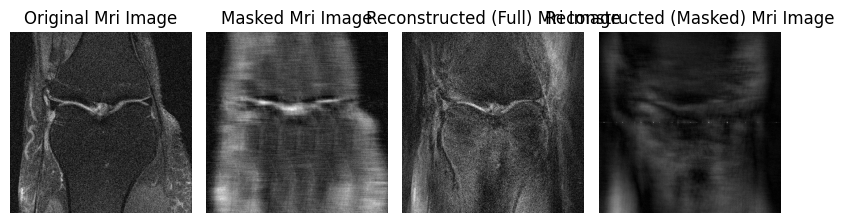

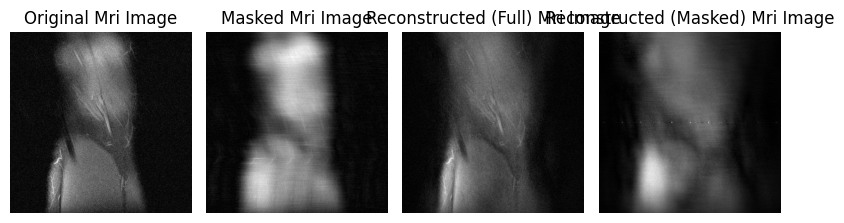

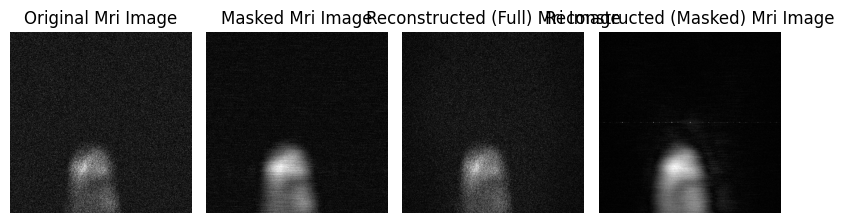

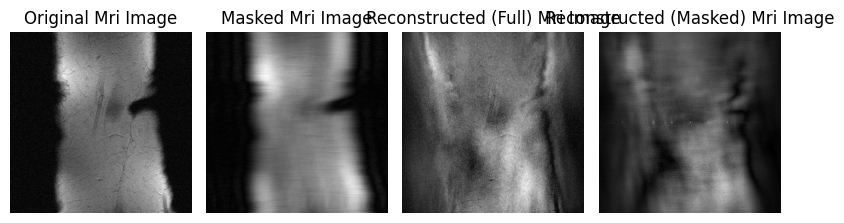

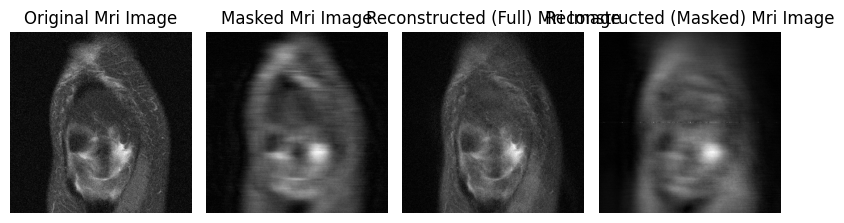

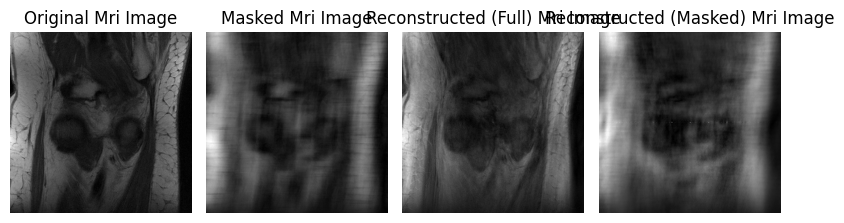

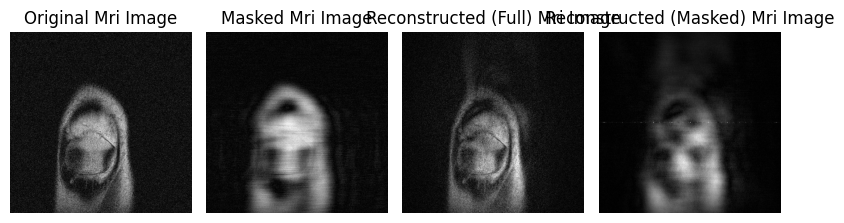

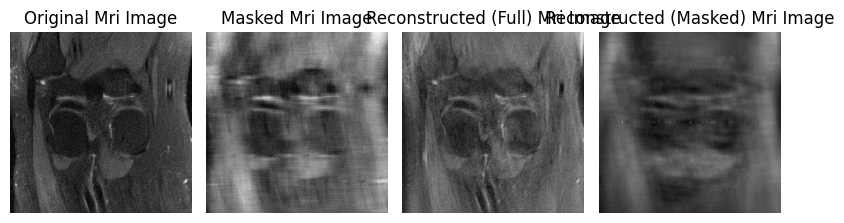

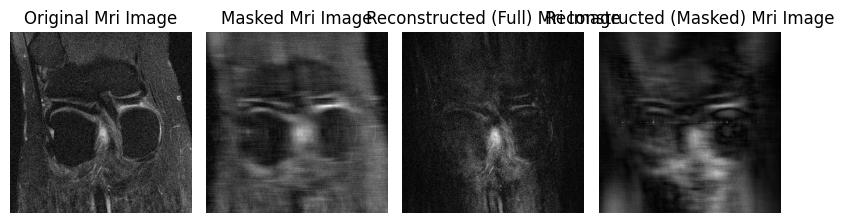

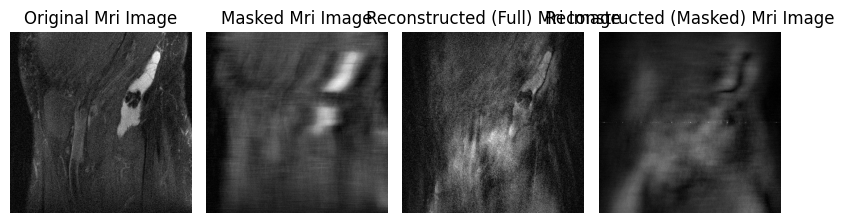

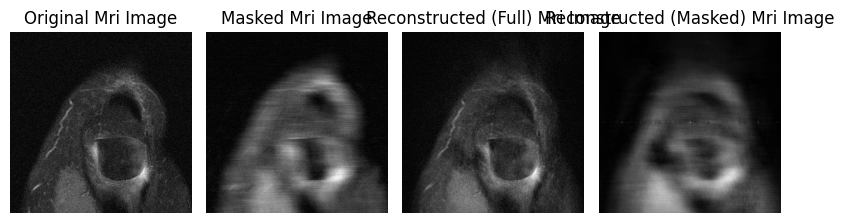

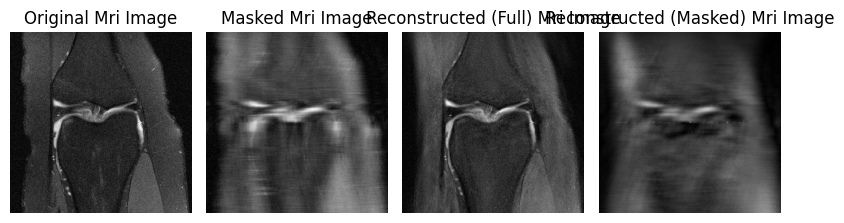

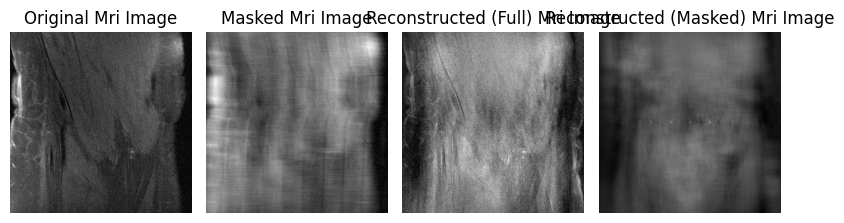

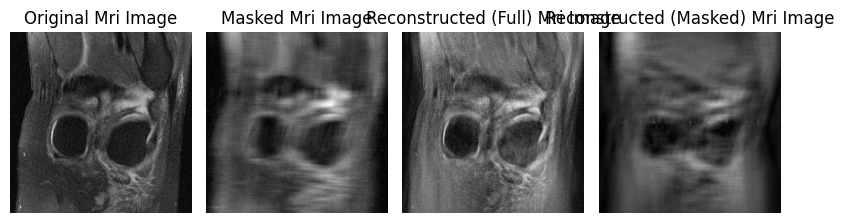

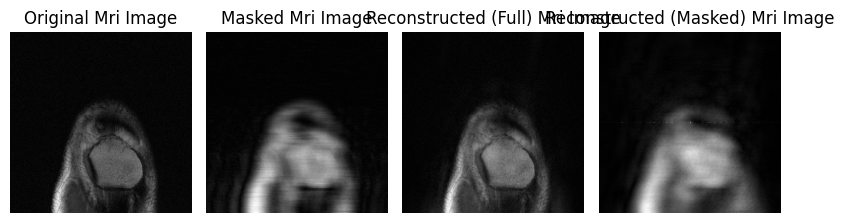

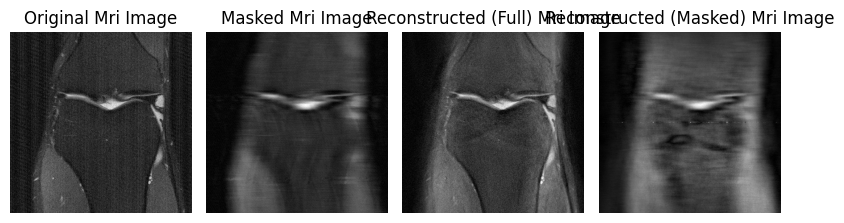

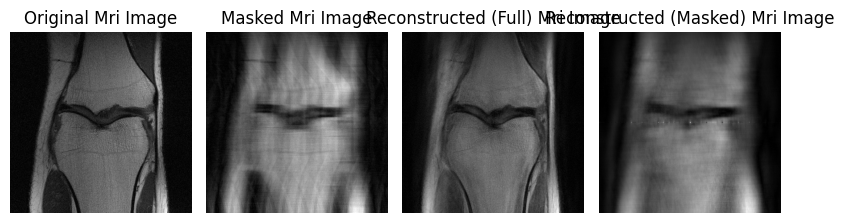

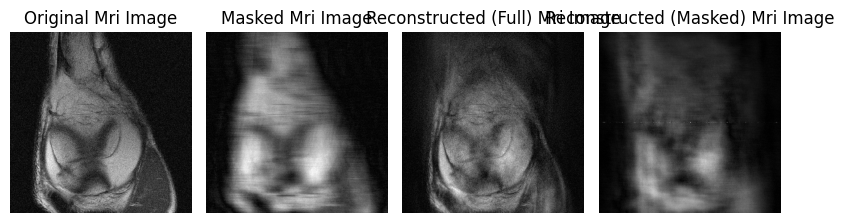

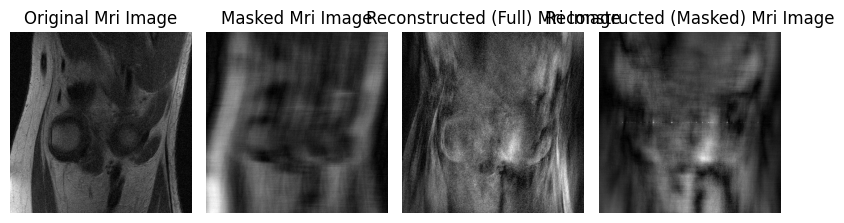

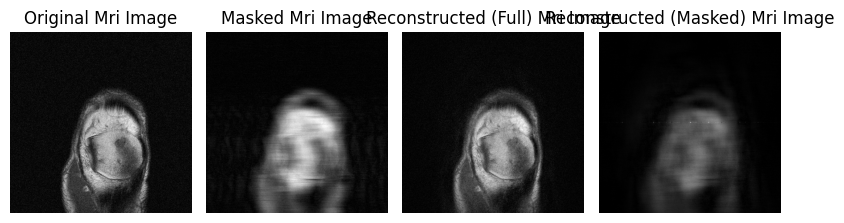

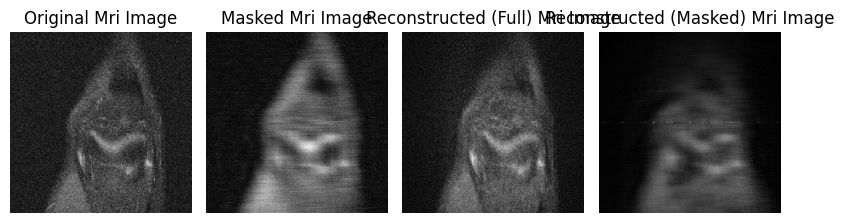

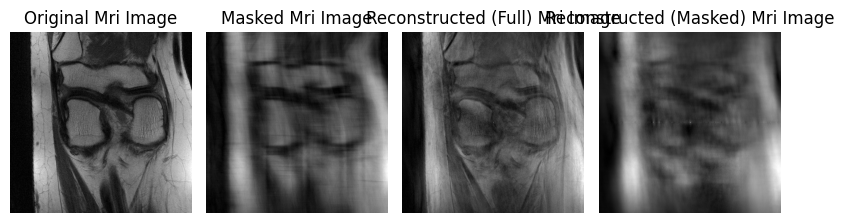

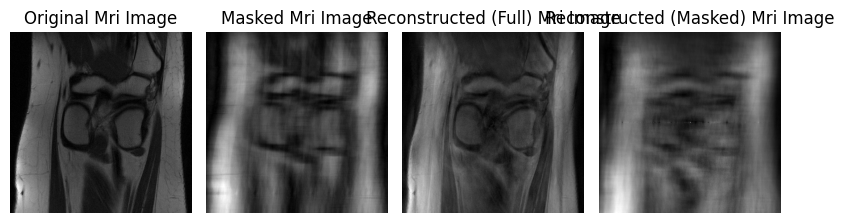

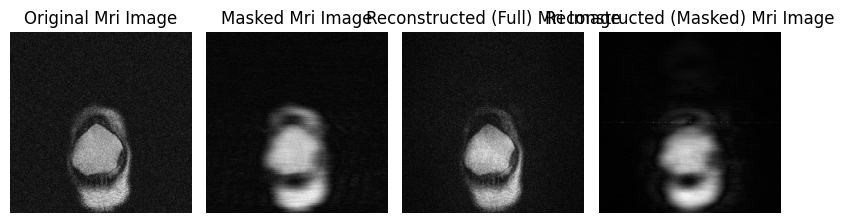

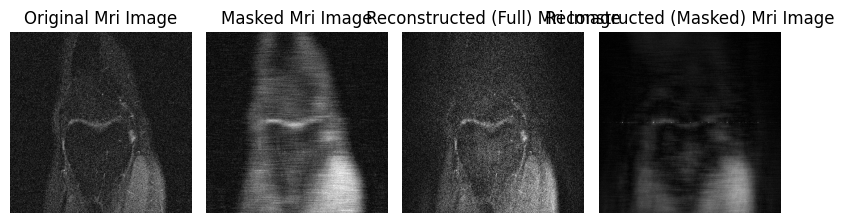

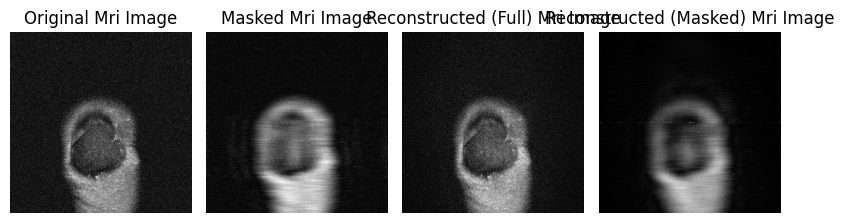

KeyboardInterrupt: 

<Figure size 800x500 with 0 Axes>

In [9]:
for batch in train_dl:
    process_batch(batch)